# Beginner-Friendly Machine Learning Tutorial: Penguins Dataset

Welcome! This notebook will guide you step-by-step through a hands-on machine learning workflow using the Palmer Penguins dataset. You will learn how to:

- Load and explore data
- Preprocess and clean data
- Build and evaluate a machine learning model
- Visualize results

**Note:** The 'island' feature is categorical and may require special attention during encoding.

Let's get started!

In [1]:
# Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 1. Setup: Import Libraries and Configure Environment

Let's import the necessary Python libraries and set up our environment.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from src.utility import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### About the Custom Machine Learning Classes

This notebook uses several custom classes from `utility.py` to simplify and enhance the machine learning workflow:

- **MetaCleanPipeline**: Automates data cleaning, feature engineering, and target encoding.
- **FeatureEngineeringSelector**: Flexible feature selection and engineering.
- **DataCleaner**: Handles missing values, scaling, encoding, and duplicate removal.
- **GraphAnalyzerEngine**: Analyzes feature importances and relationships.
- **VisualizerFactory**: Provides advanced visualizations.

These tools make the machine learning process more accessible and interpretable.

## 2. Load and Explore the Penguins Dataset

The Palmer Penguins dataset contains measurements for penguin species observed in Antarctica. Let's load the data and take a first look.

In [3]:
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## 3. Data Preprocessing: Feature Selection and Cleaning

To prepare our data for machine learning, we need to:
- Separate features (inputs) from the target (output)
- Clean and preprocess the data (handle missing values, encode categories, etc.)

**Warning:** The 'island' feature is categorical and may require special encoding. If you use label encoding, be aware that the encoded values are arbitrary and do not represent any order. One-hot encoding is often preferred for such features.

In [4]:
# Drop rows with missing target (species)
penguins = penguins.dropna(subset=['species'])
# Separate features (X) and target (y)
X = penguins.drop(columns=["species"])
y = penguins["species"]

# Convert all string columns to categorical
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

# Convert boolean columns to string/object dtype for compatibility with SimpleImputer
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(str)
print('Boolean columns converted to string:', X.select_dtypes(include=['bool']).columns.tolist())

Boolean columns converted to string: []


In [5]:
# Create and configure the data cleaning and feature engineering pipeline
meta_pipe = MetaCleanPipeline(
    drop_duplicates=True,
    feature_engineering_strategies=[{
        'name': 'model_importance',
        'model_cls': RandomForestClassifier,  # Use classifier for classification tasks
        'threshold': 'mean'
    }],
    numeric_strategy='mean',
    categorical_strategy='most_frequent',
    target_encoder_method='label',
    auto_encode_features=False,
    # You can add more cleaner_kwargs if needed
    )

# Fit the pipeline and transform the data
X_clean = meta_pipe.fit_transform(X, y)
print(X_clean.head())
print('Final features:', meta_pipe.get_selected_features())

# Retrieve cleaned features and encoded target for training
X_cleaned, y_enc = meta_pipe.get_cleaned_dataset()
y_original = meta_pipe.inverse_transform_target(y_enc)
print('y_original unique:', np.unique(y_original))
print('y_enc unique:', np.unique(y_enc))
print('shape X_cleaned:', X_cleaned.shape)
print('shape y_enc:', y_enc.shape)
y_full_enc = meta_pipe.transform_target(y_original)

# If you want to decode y_enc back to original labels:
print(meta_pipe.inverse_transform_target(np.unique(y_enc)))

   bill_length_mm  bill_depth_mm  flipper_length_mm
0   -8.870812e-01   7.877425e-01          -1.422488
1   -8.134940e-01   1.265563e-01          -1.065352
2   -6.663195e-01   4.317192e-01          -0.422507
3   -1.307172e-15   1.806927e-15           0.000000
4   -1.328605e+00   1.092905e+00          -0.565361
Final features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
y_original unique: ['Adelie' 'Chinstrap' 'Gentoo']
y_enc unique: [0 1 2]
shape X_cleaned: (344, 6)
shape y_enc: (344,)
['Adelie' 'Chinstrap' 'Gentoo']


## 4. Model Training and Evaluation

Now, let's train a machine learning model to classify penguin species. We'll:
- Split the data into training and test sets
- Train a Random Forest classifier
- Evaluate the model's performance using a classification report and confusion matrix

Classification Report:
               precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        40
   Chinstrap       0.95      1.00      0.97        18
      Gentoo       1.00      1.00      1.00        28

    accuracy                           0.99        86
   macro avg       0.98      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86



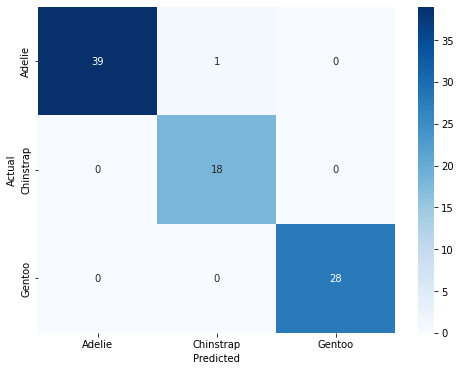

In [6]:
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_cleaned[meta_pipe.get_selected_features()],
                                                    y_original, random_state=42)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_original), yticklabels=np.unique(y_original), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

## 5. Feature Importance and Visualization

Let's use advanced visualizations to explore feature importances and relationships.

In [7]:
#convert X_cleaned feature to numeric value to display in the notebook
#example island --> to 0, 1, 2
for col in X_cleaned.select_dtypes(include=['category']).columns:
    X_cleaned[col] = X_cleaned[col].cat.codes

# Used imputer to fill missing values in X_cleaned
# This is just an example, you can use any imputer or method to fill missing values
X_cleaned = X_cleaned.fillna(X_cleaned.mean(numeric_only=True))

In [8]:
engine = GraphAnalyzerEngine()
engine.analyze(X_cleaned, pd.DataFrame(y_enc))
store = engine.get_store()
label_map = dict(enumerate(meta_pipe.get_target_encoder().classes_))
relabel_targets_in_store(store, label_map)
fig_sankey = VisualizerFactory.make_sankey(store, show_feature_feature_links=False)
fig_sankey.show()

### Bar Plot of Feature Importances

The bar plot below shows the aggregated importance of each feature. The dashed line represents the threshold for random (noise) importance. Features above this line are considered informative.

In [9]:
fig_bar = VisualizerFactory.make_bar(store, show_threshold=True, show_noise=True)
fig_bar.show()

In [23]:
# Plot t-SNE map for feature visualization
fig_tsne = VisualizerFactory.make_tsne(X_cleaned, y_enc,         
                                    perplexity=5, # Higher perplexity can help with larger datasets
                                    random_state=10)
fig_tsne.show()

## 6. Conclusion and Next Steps

Congratulations! You have completed a full machine learning workflow on the Palmer Penguins dataset:
- Data loading and exploration
- Preprocessing and cleaning
- Model training and evaluation
- Feature importance analysis and visualization

Feel free to experiment with different models, parameters, or datasets. And remember to pay special attention to categorical features like 'island'!